In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import requests
import parmap
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, RDLogger
from scipy import stats
import math
from Bio import AlignIO
from biodl.umols import Umols
from rdkit.Chem import rdmolops, Descriptors
import pickle as cPickle
import warnings
warnings.filterwarnings('ignore')
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# BindingDB
https://www.bindingdb.org/rwd/bind/index.jsp

In [4]:
# # https://www.bindingdb.org/bind/chemsearch/marvin/SDFdownload.jsp?download_file=/bind/downloads/BindingDB_All_2022m5.tsv.zip
# !wget https://www.bindingdb.org/bind/downloads/BindingDB_All_2022m6.tsv.zip
# !unzip BindingDB_All_2022m6.tsv.zip

# with open('./BindingDB_All.tsv') as f:
#     lines = f.readlines()
# cols = lines[0].split('\t')[:24]
# data1 = []
# for line in lines[1:]:
#     data1.append(line.split('http://www.bindingdb.org/')[0].split('\t'))
# data2 = []
# for line in lines[1:]:
#     dlist = []
#     da = line.split('submit=Search')[-1].split('\t')[-9:]
#     dat = [d.split(',') for d in da]
#     for da in dat:
#         if len(da[0]) > 0:
#             for d in da:
#                 if len(d) == 6:
#                     dlist.append(d)
                    
#     if len(dlist) > 0: 
#         data2.append(','.join(dlist))
#     else:
#         data2.append('NaN')
# bdb = pd.DataFrame(data1, columns=cols)
# bdb['Entry'] = [d.split(',')[0] for d in data2]
# bdb = bdb[bdb['Entry'] != 'NaN'].reset_index(drop=True)
# bindingdb = bdb[['Entry', 'Ligand SMILES', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)']]
# bindingdb.columns = ['Entry', 'SMILES', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)']
# bindingdb = bindingdb.dropna(subset=['Entry', 'SMILES', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)']).reset_index(drop=True)
# bindingdb

In [5]:
# bindingdb.to_csv('./BindingDB/BindingDB_All.csv', index=False)

In [7]:
bindingdb = pd.read_csv('./BindingDB/BindingDB_All.csv')
bindingdb

,Entry,SMILES,Ki (nM),IC50 (nM),Kd (nM)
0,P08684,Cc1nc(CN2CCN(CC2)c2c(Cl)cnc3[nH]c(nc23)-c2cn(C...,NaN,>50000,NaN
1,P51570,O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...,NaN,6676.9,NaN
2,P42574,CN(Cc1ccc(s1)C(=O)N[C@@H](CC(O)=O)C(=O)CSCc1cc...,90,NaN,NaN
3,P29466,OC(=O)C[C@H](NC(=O)c1ccc(CNS(=O)(=O)c2ccc(O)c(...,160,NaN,NaN
4,P29466,OC(=O)C[C@H](NC(=O)c1ccc(CNS(=O)(=O)c2ccc(O)c(...,3900,NaN,NaN
...,...,...,...,...,...
2248535,P11712,COc1cc(ccc1-n1cnc(C)c1)C1=CC2=NOC[C@@H](N2CCC1...,NaN,8000,NaN
2248536,P10635,COc1cc(\C=C2/CCCN3[C@@H](C)[C@H](ON=C23)c2cc(F...,NaN,49000,NaN
2248537,P10635,COc1cc(\C=C2/CCCN3[C@@H](C)[C@H](ON=C23)c2cc(F...,NaN,49000,NaN
2248538,P10635,COc1cc(ccc1-n1cnc(C)c1)C1=CC2=NO[C@@H](CN2CCC1...,NaN,48000,NaN


In [9]:
bindingdb.shape[0], len(list(set(bindingdb['Entry'].tolist()))), len(list(set(bindingdb['SMILES'].tolist())))

(2248540, 6787, 986082)

# Metz
https://www.nature.com/articles/nchembio.530#Sec3

In [10]:
metz = pd.read_csv('./Metz/metz_data.csv')
metz['IC50 (nM)'] = 'NaN'
metz = metz[['Entry', 'SMILES', 'Ki (nM)', 'IC50 (nM)']]
metz = metz.dropna(subset=['Entry', 'SMILES']).reset_index(drop=True)
metz

,Entry,SMILES,Ki (nM),IC50 (nM)
0,P50613,NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1,630.957344480193,NaN
1,P49336,NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1,199.52623149688787,NaN
2,P50750,NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1,158.48931924611142,NaN
3,O14757,NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1,1584.893192461114,NaN
4,P49760,NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1,6.309573444801943,NaN
...,...,...,...,...
100414,Q9UQM7,Brc1ccc2cnc(Nc3ccncn3)cc2c1,<3981.071705534969,NaN
100415,Q00535,Brc1ccc2cnc(Nc3ccncn3)cc2c1,158.48931924611142,NaN
100416,P00519,Brc1ccc2cnc(Nc3ccncn3)cc2c1,<2511.886431509582,NaN
100417,Q07912,Brc1ccc2cnc(Nc3ccncn3)cc2c1,<3981.071705534969,NaN


In [11]:
metz.shape[0], len(list(set(metz['Entry'].tolist()))), len(list(set(metz['SMILES'].tolist())))

(100419, 172, 1384)

# Drug Target Commons
https://drugtargetcommons.fimm.fi/

In [13]:
dtc = pd.read_csv('./DTC/dtc.csv')
dtc

,Entry,SMILES,Ki (nM),IC50 (nM)
0,P49137,CC1CNC(=O)c2[nH]c3ccc(C(=O)N(C)C)cc3c21,NaN,>20000.000000000004
1,P04626,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,NaN,=63.999999999999986
2,P00533,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,NaN,=188.00000000000009
3,P06239,Cc1ccc(O)cc1Nc1cc(N2CCOCC2)nc(-n2cnc3ccccc32)n1,NaN,=136.99999999999997
4,P35968,Nc1ccccc1NC(=O)c1ccc(C(=O)Nc2cccc(Nc3ncc(-c4cc...,NaN,=12000.000000000007
...,...,...,...,...
281557,P00533,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=1584.8899999999994,NaN
281558,O60674,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=794.3299999999991,NaN
281559,O14757,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,>7943.280000000002,NaN
281560,O00444,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=3162.280000000004,NaN


In [14]:
dtc.shape[0], len(list(set(dtc['Entry'].tolist()))), len(list(set(dtc['SMILES'].tolist())))

(281562, 370, 74119)

# Dunbrack MSA
https://www.nature.com/articles/s41598-019-56499-4

In [15]:
align = AlignIO.read("./Dunbrack/si1.txt", "clustal")
names = []
seqs = []
pos = []
for record in align:
    if '0ANNOTATION' not in str(record.id):
        names.append(str(record.id).split('/')[0].split('_')[1]+'_HUMAN')
        seqs.append(str(record.seq))
        pos.append(str(record.id).split('/')[1])

dunbrack = pd.DataFrame({'Name':names, 'MSA':seqs, 'Position':pos})
dunbrack

,Name,MSA,Position
0,AKT1_HUMAN,FEYL----------------KLLGKGT----------------FGK...,150-408
1,AKT2_HUMAN,FDYL----------------KLLGKGT----------------FGK...,152-409
2,AKT3_HUMAN,FDYL----------------KLLGKGT----------------FGK...,148-405
3,CDC42BPA_HUMAN,FEIL----------------KVIGRGA----------------FGE...,77-343
4,CDC42BPB_HUMAN,FEII----------------KVIGRGA----------------FGE...,76-342
...,...,...,...
492,TYK2_HUMAN,ITQL----------------SHLGQGT----------------RTN...,589-868
493,TYK2_HUMAN,LKKI----------------RDLGEGH----------------FGK...,897-1171
494,TYRO3_HUMAN,FTLG----------------RMLGKGE----------------FGS...,518-788
495,YES1_HUMAN,LRLE----------------VKLGQGC----------------FGE...,277-528


In [16]:
si5 = pd.read_excel('./Dunbrack/si5.xlsx')
for i in range(si5.shape[0]):
    if '_' in si5['2_Gene'].iloc[i]:
        si5['2_Gene'].iloc[i] = si5['2_Gene'].iloc[i][:-2]
si5 = si5.drop_duplicates(['2_Gene'], keep='first').reset_index(drop=True)
si5

,1_Group,2_Gene,3_HGNC,4_Uni_entry,5_Uni_acc,6_Domain_begin,7_Domain_end,8_Domain_length,9_Largest_insert_length,10_PDB_validation,11_Conformational_state,12_Dihedral_state,13_Group_in_Uni,14_Group_in_Manning,15_Synonymn
0,AGC,AKT1,HGNC:391,AKT1_HUMAN,P31749,150,408,259,9,6NPZB,DFGin,BLAminus,AGC,AGC,"PKB,RAC"
1,AGC,AKT2,HGNC:392,AKT2_HUMAN,P31751,152,409,258,9,3E8DB,DFGin,BLAminus,AGC,AGC,NaN
2,AGC,AKT3,HGNC:393,AKT3_HUMAN,Q9Y243,148,405,258,9,NaN,NaN,NaN,AGC,AGC,PKBG
3,AGC,CDC42BPA,HGNC:1737,MRCKA_HUMAN,Q5VT25,77,343,267,14,NaN,NaN,NaN,AGC,AGC,KIAA0451
4,AGC,CDC42BPB,HGNC:1738,MRCKB_HUMAN,Q9Y5S2,76,342,267,14,5OTFA,DFGin,BLAminus,AGC,AGC,KIAA1124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,TYR,TXK,HGNC:12434,TXK_HUMAN,P42681,271,522,252,10,NaN,NaN,NaN,TYR,TYR,"PTK4,RLK"
480,TYR,TYK2,HGNC:12440,TYK2_HUMAN,P29597,589,868,280,26,3ZONA,DFGin,NaN,TYR,TYR,NaN
481,TYR,TYRO3,HGNC:12446,TYRO3_HUMAN,Q06418,518,788,271,10,NaN,NaN,NaN,TYR,TYR,"BYK,DTK,RSE,SKY,TIF"
482,TYR,YES1,HGNC:12841,YES_HUMAN,P07947,277,528,252,10,NaN,NaN,NaN,TYR,TYR,YES


In [17]:
name_entry = {}
for i in range(si5.shape[0]):
    name_entry[si5['2_Gene'].iloc[i]+'_HUMAN'] = si5['5_Uni_acc'].iloc[i]

In [18]:
dunbrack['Entry'] = 0
for i in range(dunbrack.shape[0]):
    dunbrack['Entry'].iloc[i] = name_entry[dunbrack['Name'].iloc[i]]

In [19]:
dunbrack

,Name,MSA,Position,Entry
0,AKT1_HUMAN,FEYL----------------KLLGKGT----------------FGK...,150-408,P31749
1,AKT2_HUMAN,FDYL----------------KLLGKGT----------------FGK...,152-409,P31751
2,AKT3_HUMAN,FDYL----------------KLLGKGT----------------FGK...,148-405,Q9Y243
3,CDC42BPA_HUMAN,FEIL----------------KVIGRGA----------------FGE...,77-343,Q5VT25
4,CDC42BPB_HUMAN,FEII----------------KVIGRGA----------------FGE...,76-342,Q9Y5S2
...,...,...,...,...
492,TYK2_HUMAN,ITQL----------------SHLGQGT----------------RTN...,589-868,P29597
493,TYK2_HUMAN,LKKI----------------RDLGEGH----------------FGK...,897-1171,P29597
494,TYRO3_HUMAN,FTLG----------------RMLGKGE----------------FGS...,518-788,Q06418
495,YES1_HUMAN,LRLE----------------VKLGQGC----------------FGE...,277-528,P07947


In [ ]:
# 2개 이상의 도메인을 가지는 키나아제를 확인합니다.
# Check kinases with two or more domains.

In [20]:
dunbrack['Diff'] = 0
for i in range(dunbrack.shape[0]):
    if dunbrack[dunbrack['Name'] == dunbrack['Name'].iloc[i]].shape[0] > 1:
        dunbrack['Diff'].iloc[i] = 1
dunbrack

,Name,MSA,Position,Entry,Diff
0,AKT1_HUMAN,FEYL----------------KLLGKGT----------------FGK...,150-408,P31749,0
1,AKT2_HUMAN,FDYL----------------KLLGKGT----------------FGK...,152-409,P31751,0
2,AKT3_HUMAN,FDYL----------------KLLGKGT----------------FGK...,148-405,Q9Y243,0
3,CDC42BPA_HUMAN,FEIL----------------KVIGRGA----------------FGE...,77-343,Q5VT25,0
4,CDC42BPB_HUMAN,FEII----------------KVIGRGA----------------FGE...,76-342,Q9Y5S2,0
...,...,...,...,...,...
492,TYK2_HUMAN,ITQL----------------SHLGQGT----------------RTN...,589-868,P29597,1
493,TYK2_HUMAN,LKKI----------------RDLGEGH----------------FGK...,897-1171,P29597,1
494,TYRO3_HUMAN,FTLG----------------RMLGKGE----------------FGS...,518-788,Q06418,0
495,YES1_HUMAN,LRLE----------------VKLGQGC----------------FGE...,277-528,P07947,0


In [21]:
diffdunb = dunbrack[dunbrack['Diff'] == 1].reset_index(drop=True)
diffkis = list(set(diffdunb['Entry'].tolist()))
diffdunb

,Name,MSA,Position,Entry,Diff
0,RPS6KA1_HUMAN,FELL----------------KVLGQGS----------------FGK...,62-321,Q15418,1
1,RPS6KA2_HUMAN,FELL----------------KVLGQGS----------------YGK...,59-318,Q15349,1
2,RPS6KA3_HUMAN,FELL----------------KVLGQGS----------------FGK...,68-327,P51812,1
3,RPS6KA4_HUMAN,FELL----------------KVLGTGA----------------YGK...,33-301,O75676,1
4,RPS6KA5_HUMAN,FELL----------------KVLGTGA----------------YGK...,49-318,O75582,1
5,RPS6KA6_HUMAN,FELL----------------KVLGQGS----------------FGK...,73-330,Q9UK32,1
6,OBSCN_HUMAN,YEVK----------------EEIGRGV----------------FGF...,6468-6721,Q5VST9,1
7,OBSCN_HUMAN,FAFQ----------------TQIQRGR----------------FSV...,7672-7924,Q5VST9,1
8,RPS6KA1_HUMAN,YVVK----------------ETIGVGS----------------YSE...,418-675,Q15418,1
9,RPS6KA2_HUMAN,YEIK----------------EDIGVGS----------------YSV...,415-672,Q15349,1


In [22]:
diffkis, len(diffkis)

(['O75582',
  'P23458',
  'P52333',
  'Q5VST9',
  'Q9UK32',
  'P29597',
  'Q15772',
  'Q15349',
  'O75676',
  'Q15418',
  'P51812',
  'O60674',
  'Q9P2K8'],
 13)

In [23]:
dunbkinase = list(set(dunbrack['Entry'].tolist()))
len(dunbkinase)

484

In [24]:
bindingdb['DB'] = 'BindingDB'
metz['DB'] = 'Metz'
dtc['DB'] = 'DTC'

In [25]:
entrydict = {}
for i in range(dunbrack.shape[0]):
    entrydict[dunbrack['Entry'].iloc[i]] = dunbrack['Name'].iloc[i]

In [26]:
hkdf = pd.concat([bindingdb, metz, dtc]).reset_index(drop=True)
hkdf

,Entry,SMILES,Ki (nM),IC50 (nM),Kd (nM),DB
0,P08684,Cc1nc(CN2CCN(CC2)c2c(Cl)cnc3[nH]c(nc23)-c2cn(C...,NaN,>50000,NaN,BindingDB
1,P51570,O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...,NaN,6676.9,NaN,BindingDB
2,P42574,CN(Cc1ccc(s1)C(=O)N[C@@H](CC(O)=O)C(=O)CSCc1cc...,90,NaN,NaN,BindingDB
3,P29466,OC(=O)C[C@H](NC(=O)c1ccc(CNS(=O)(=O)c2ccc(O)c(...,160,NaN,NaN,BindingDB
4,P29466,OC(=O)C[C@H](NC(=O)c1ccc(CNS(=O)(=O)c2ccc(O)c(...,3900,NaN,NaN,BindingDB
...,...,...,...,...,...,...
2630516,P00533,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=1584.8899999999994,NaN,NaN,DTC
2630517,O60674,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=794.3299999999991,NaN,NaN,DTC
2630518,O14757,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,>7943.280000000002,NaN,NaN,DTC
2630519,O00444,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=3162.280000000004,NaN,NaN,DTC


In [27]:
def getname(e):
    try:
        return entrydict[e]
    except:
        return 0

In [28]:
names = parmap.map(getname, hkdf['Entry'].tolist(), 
                    pm_pbar=True, pm_processes=100)

hkdf['Name'] = names
hkdf = hkdf[hkdf['Name'] != 0].reset_index(drop=True)
hkdf

  0%|          | 0/2630521 [00:00<?, ?it/s]

,Entry,SMILES,Ki (nM),IC50 (nM),Kd (nM),DB,Name
0,Q05397,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCNCCc4c3)nc12,NaN,1033.14,NaN,BindingDB,PTK2_HUMAN
1,Q05397,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,NaN,1999,NaN,BindingDB,PTK2_HUMAN
2,O60674,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,NaN,16.54,NaN,BindingDB,JAK2_HUMAN
3,P52333,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,NaN,226.9,NaN,BindingDB,JAK3_HUMAN
4,Q05397,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,NaN,2999,NaN,BindingDB,PTK2_HUMAN
...,...,...,...,...,...,...,...
805162,P00533,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=1584.8899999999994,NaN,NaN,DTC,EGFR_HUMAN
805163,O60674,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=794.3299999999991,NaN,NaN,DTC,JAK2_HUMAN
805164,O14757,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,>7943.280000000002,NaN,NaN,DTC,CHEK1_HUMAN
805165,O00444,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=3162.280000000004,NaN,NaN,DTC,PLK4_HUMAN


In [29]:
def getkinase(entry):
    if entry in dunbkinase:
        return 1
    else:
        return 0

In [30]:
kinases = parmap.map(getkinase, hkdf['Entry'].tolist(), 
                    pm_pbar=True, pm_processes=100)

hkdf['Kinase'] = kinases
hkdf = hkdf[hkdf['Kinase'] == 1].reset_index(drop=True)
hkdf

  0%|          | 0/805167 [00:00<?, ?it/s]

,Entry,SMILES,Ki (nM),IC50 (nM),Kd (nM),DB,Name,Kinase
0,Q05397,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCNCCc4c3)nc12,NaN,1033.14,NaN,BindingDB,PTK2_HUMAN,1
1,Q05397,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,NaN,1999,NaN,BindingDB,PTK2_HUMAN,1
2,O60674,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,NaN,16.54,NaN,BindingDB,JAK2_HUMAN,1
3,P52333,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,NaN,226.9,NaN,BindingDB,JAK3_HUMAN,1
4,Q05397,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,NaN,2999,NaN,BindingDB,PTK2_HUMAN,1
...,...,...,...,...,...,...,...,...
805162,P00533,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=1584.8899999999994,NaN,NaN,DTC,EGFR_HUMAN,1
805163,O60674,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=794.3299999999991,NaN,NaN,DTC,JAK2_HUMAN,1
805164,O14757,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,>7943.280000000002,NaN,NaN,DTC,CHEK1_HUMAN,1
805165,O00444,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=3162.280000000004,NaN,NaN,DTC,PLK4_HUMAN,1


In [31]:
hkdf.shape[0], len(list(set(hkdf['Entry'].tolist()))), len(list(set(hkdf['SMILES'].tolist())))

(805167, 422, 241332)

In [32]:
Entry = []
EntryName = []
LigandSMILES = []
Qualifier = []
nMValue = []
log10nMValue = []
Type = []
DB = []
for i in tqdm(range(hkdf.shape[0])):
    tp = []
    if str(hkdf['Ki (nM)'].iloc[i]) != 'nan':
        tp.extend(['Ki (nM)'])
    if str(hkdf['IC50 (nM)'].iloc[i]) != 'nan':
        tp.extend(['IC50 (nM)'])
    for t in tp:
        Entry.append(hkdf['Entry'].iloc[i])
        EntryName.append(hkdf['Name'].iloc[i])
        LigandSMILES.append(hkdf['SMILES'].iloc[i])
        try:
            if '>' in str(hkdf[t].iloc[i]):
                v = float(hkdf[t].iloc[i].replace(' ', '').replace('=', '').replace('>', ''))
                Qualifier.append('>')
            elif '<' in str(hkdf[t].iloc[i]):
                v = float(hkdf[t].iloc[i].replace(' ', '').replace('=', '').replace('<', ''))
                Qualifier.append('<')
            elif '=' in str(hkdf[t].iloc[i]):
                v = float(hkdf[t].iloc[i].replace(' ', '').replace('=', ''))
                Qualifier.append('=')
            else:
                v = float(hkdf[t].iloc[i])
                Qualifier.append('=')
        except:
            print(hkdf[t].iloc[i])
            Qualifier.append('Wrong')
        nMValue.append(v)
        try:
            log10nMValue.append(math.log10(v))
        except:
            log10nMValue.append('NaN')
        Type.append(t.replace(' (nM)', ''))
        DB.append(hkdf['DB'].iloc[i])

  0%|          | 0/805167 [00:00<?, ?it/s]

~4000.000000000001
~1600000.000000001
nan2.9999999999999996
nan2.9999999999999996
nan57.99999999999998
nan3387.9999999999995
nan0.8000000000000003
nan460.0000000000003
nan905.0000000000009
~100000.0
~100000.0
nan0.4
nan29.999999999999996
~30000.00000000001
~46000.00000000003


In [33]:
hkdf = pd.DataFrame({'Entry':Entry, 
                     'Name':EntryName, 
                     'smiles':LigandSMILES, 
                     'Qualifier':Qualifier, 
                     'Value (nM)':nMValue, 
                     'Value (log10nM)':log10nMValue, 
                     'Type':Type, 
                     'DB':DB})

hkdf = hkdf[hkdf['Value (log10nM)'] != 'NaN'].reset_index(drop=True)
hkdf = hkdf[hkdf['Qualifier'] != 'Wrong'].reset_index(drop=True)
hkdf = hkdf.dropna().reset_index(drop=True)
hkdf

,Entry,Name,smiles,Qualifier,Value (nM),Value (log10nM),Type,DB
0,Q05397,PTK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCNCCc4c3)nc12,=,1033.14,3.014159,IC50,BindingDB
1,Q05397,PTK2_HUMAN,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,=,1999.00,3.300813,IC50,BindingDB
2,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.54,1.218536,IC50,BindingDB
3,P52333,JAK3_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,226.90,2.355834,IC50,BindingDB
4,Q05397,PTK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,2999.00,3.476976,IC50,BindingDB
...,...,...,...,...,...,...,...,...
737937,P00533,EGFR_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,1584.89,3.199999,Ki,DTC
737938,O60674,JAK2_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,794.33,2.900001,Ki,DTC
737939,O14757,CHEK1_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,>,7943.28,3.900000,Ki,DTC
737940,O00444,PLK4_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,3162.28,3.500000,Ki,DTC


In [35]:
hkdf.to_csv('hkdfall.csv', index=False)

In [36]:
hkdf = pd.read_csv('hkdfall.csv')
hkdf

,Entry,Name,smiles,Qualifier,Value (nM),Value (log10nM),Type,DB
0,Q05397,PTK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCNCCc4c3)nc12,=,1033.14,3.014159,IC50,BindingDB
1,Q05397,PTK2_HUMAN,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,=,1999.00,3.300813,IC50,BindingDB
2,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.54,1.218536,IC50,BindingDB
3,P52333,JAK3_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,226.90,2.355834,IC50,BindingDB
4,Q05397,PTK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,2999.00,3.476976,IC50,BindingDB
...,...,...,...,...,...,...,...,...
737937,P00533,EGFR_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,1584.89,3.199999,Ki,DTC
737938,O60674,JAK2_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,794.33,2.900001,Ki,DTC
737939,O14757,CHEK1_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,>,7943.28,3.900000,Ki,DTC
737940,O00444,PLK4_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,3162.28,3.500000,Ki,DTC


In [37]:
hkdf.value_counts(['DB'])

DB       
BindingDB    356359
DTC          281547
Metz         100036
dtype: int64

In [ ]:
# 상관관계가 높은 IC50와 Ki만 함께 사용합니다.
# Use only the highly correlated IC50 and Ki together.
# https://pubs.rsc.org/en/content/articlelanding/2017/ra/c7ra07167a

In [38]:
IC50df = hkdf[hkdf['Type'] == 'IC50'].reset_index(drop=True)
Kidf = hkdf[hkdf['Type'] == 'Ki'].reset_index(drop=True)
hkdf = pd.concat([IC50df, Kidf]).reset_index(drop=True)
hkdf

,Entry,Name,smiles,Qualifier,Value (nM),Value (log10nM),Type,DB
0,Q05397,PTK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCNCCc4c3)nc12,=,1033.14,3.014159,IC50,BindingDB
1,Q05397,PTK2_HUMAN,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,=,1999.00,3.300813,IC50,BindingDB
2,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.54,1.218536,IC50,BindingDB
3,P52333,JAK3_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,226.90,2.355834,IC50,BindingDB
4,Q05397,PTK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,2999.00,3.476976,IC50,BindingDB
...,...,...,...,...,...,...,...,...
737937,P00533,EGFR_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,1584.89,3.199999,Ki,DTC
737938,O60674,JAK2_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,794.33,2.900001,Ki,DTC
737939,O14757,CHEK1_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,>,7943.28,3.900000,Ki,DTC
737940,O00444,PLK4_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,3162.28,3.500000,Ki,DTC


In [39]:
hkdf.shape[0], len(list(set(hkdf['Entry'].tolist()))), len(list(set(hkdf['smiles'].tolist())))

(737942, 404, 232831)

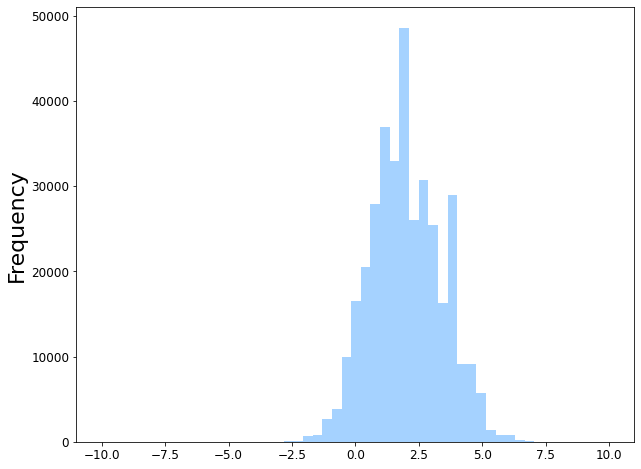

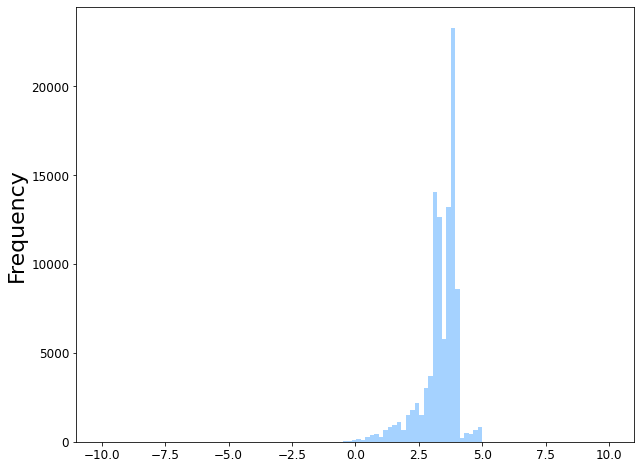

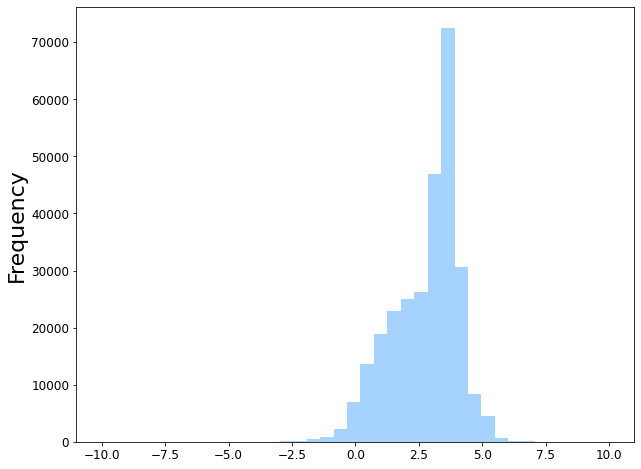

In [40]:
al = 0.2
lw = 2

hkdf[hkdf['DB'] == 'BindingDB']
hkdf[hkdf['DB'] == 'Metz']
hkdf[hkdf['DB'] == 'DTC']
plt.figure(figsize=(10, 8))
plt.hist(hkdf[hkdf['DB'] == 'BindingDB']['Value (log10nM)'].tolist(), 
         color="dodgerblue", alpha=0.4, bins=40)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-11, 11])
plt.show()

plt.figure(figsize=(10, 8))
plt.hist(hkdf[hkdf['DB'] == 'Metz']['Value (log10nM)'].tolist(), 
         color="dodgerblue", alpha=0.4, bins=40)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-11, 11])
plt.show()

plt.figure(figsize=(10, 8))
plt.hist(hkdf[hkdf['DB'] == 'DTC']['Value (log10nM)'].tolist(), 
         color="dodgerblue", alpha=0.4, bins=40)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-11, 11])
plt.show()

In [41]:
def getdunb(entry):
    msa = dunbrack[dunbrack['Entry'] == entry]['MSA'].iloc[0]
    pos = dunbrack[dunbrack['Entry'] == entry]['Position'].iloc[0]
    return msa, pos

In [42]:
dunbs = parmap.map(getdunb, hkdf['Entry'].tolist(), 
                   pm_pbar=True, pm_processes=100)

hkdf['MSA'] = [d[0] for d in dunbs]
hkdf['Position'] = [d[1] for d in dunbs]
hkdf

  0%|          | 0/737942 [00:00<?, ?it/s]

,Entry,Name,smiles,Qualifier,Value (nM),Value (log10nM),Type,DB,MSA,Position
0,Q05397,PTK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCNCCc4c3)nc12,=,1033.14,3.014159,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678
1,Q05397,PTK2_HUMAN,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,=,1999.00,3.300813,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678
2,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.54,1.218536,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807
3,P52333,JAK3_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,226.90,2.355834,IC50,BindingDB,LEWH----------------ENLGHGS----------------FTK...,521-779
4,Q05397,PTK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,2999.00,3.476976,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678
...,...,...,...,...,...,...,...,...,...,...
737937,P00533,EGFR_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,1584.89,3.199999,Ki,DTC,FKKI----------------KVLGSGA----------------FGT...,712-970
737938,O60674,JAK2_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,794.33,2.900001,Ki,DTC,LIFN----------------ESLGQGT----------------FTK...,545-807
737939,O14757,CHEK1_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,>,7943.28,3.900000,Ki,DTC,WDLV----------------QTLGEGA----------------YGE...,9-265
737940,O00444,PLK4_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,3162.28,3.500000,Ki,DTC,FKVG----------------NLLGKGS----------------FAG...,12-265


In [43]:
def getcsmi(smi):
    try:
        m = Chem.MolFromSmiles(smi)
        mols = rdmolops.GetMolFrags(m, asMols=True)
        m0 = max(mols, key=lambda m: m.GetNumAtoms())
        csmi = Chem.MolToSmiles(m0, isomericSmiles=True, canonical=True)
        return csmi
    except:
        return 0

In [44]:
csmi = parmap.map(getcsmi, hkdf['smiles'].tolist(), 
                  pm_pbar=True, pm_processes=100)

hkdf['SMILES'] = csmi
hkdf = hkdf[hkdf['SMILES'] != 0].reset_index(drop=True)
hkdf

  0%|          | 0/737942 [00:00<?, ?it/s]

,Entry,Name,smiles,Qualifier,Value (nM),Value (log10nM),Type,DB,MSA,Position,SMILES
0,Q05397,PTK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCNCCc4c3)nc12,=,1033.14,3.014159,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCNCC6)nc34)cc...
1,Q05397,PTK2_HUMAN,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,=,1999.00,3.300813,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...
2,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.54,1.218536,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...
3,P52333,JAK3_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,226.90,2.355834,IC50,BindingDB,LEWH----------------ENLGHGS----------------FTK...,521-779,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...
4,Q05397,PTK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,2999.00,3.476976,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...
...,...,...,...,...,...,...,...,...,...,...,...
737334,P00533,EGFR_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,1584.89,3.199999,Ki,DTC,FKKI----------------KVLGSGA----------------FGT...,712-970,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C
737335,O60674,JAK2_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,794.33,2.900001,Ki,DTC,LIFN----------------ESLGQGT----------------FTK...,545-807,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C
737336,O14757,CHEK1_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,>,7943.28,3.900000,Ki,DTC,WDLV----------------QTLGEGA----------------YGE...,9-265,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C
737337,O00444,PLK4_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,3162.28,3.500000,Ki,DTC,FKVG----------------NLLGKGS----------------FAG...,12-265,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C


In [45]:
hkdf.shape[0], len(list(set(hkdf['Entry'].tolist()))), len(list(set(hkdf['SMILES'].tolist())))

(737339, 404, 179699)

In [ ]:
# 부등호가 있는 데이터는 랜덤값을 더합니다.
# Data with an inequality sign adds random values.

In [46]:
def addrand(inputs):
    value, qualifier = inputs
    rand = np.random.rand()
    if qualifier == '=':
        return value
    elif qualifier == '>':
        return value+(rand*(int(value)+1)*0.01)
    elif qualifier == '<':
        return value-(rand*(int(value)+1)*0.01)

In [47]:
rands = parmap.map(addrand, [[v, q] for v, q in zip(hkdf['Value (log10nM)'].tolist(), hkdf['Qualifier'].tolist())], 
                   pm_pbar=True, pm_processes=100)

hkdf['Value (log10nM, +R)'] = rands
hkdf

  0%|          | 0/737339 [00:00<?, ?it/s]

,Entry,Name,smiles,Qualifier,Value (nM),Value (log10nM),Type,DB,MSA,Position,SMILES,"Value (log10nM, +R)"
0,Q05397,PTK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCNCCc4c3)nc12,=,1033.14,3.014159,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCNCC6)nc34)cc...,3.014159
1,Q05397,PTK2_HUMAN,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,=,1999.00,3.300813,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...,3.300813
2,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.54,1.218536,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,1.218536
3,P52333,JAK3_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,226.90,2.355834,IC50,BindingDB,LEWH----------------ENLGHGS----------------FTK...,521-779,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,2.355834
4,Q05397,PTK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,2999.00,3.476976,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,3.476976
...,...,...,...,...,...,...,...,...,...,...,...,...
737334,P00533,EGFR_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,1584.89,3.199999,Ki,DTC,FKKI----------------KVLGSGA----------------FGT...,712-970,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,3.199999
737335,O60674,JAK2_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,794.33,2.900001,Ki,DTC,LIFN----------------ESLGQGT----------------FTK...,545-807,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,2.900001
737336,O14757,CHEK1_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,>,7943.28,3.900000,Ki,DTC,WDLV----------------QTLGEGA----------------YGE...,9-265,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,3.928701
737337,O00444,PLK4_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,3162.28,3.500000,Ki,DTC,FKVG----------------NLLGKGS----------------FAG...,12-265,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,3.500000


In [ ]:
# 위에서 랜덤값을 더했으므로 이 과정 이후 데이터 개수는 항상 다를 수 있습니다.
# Since we added random values above, the number of data points after this process can always be different.

In [ ]:
# 중복 데이터는 아웃라이어 제거 후에 그들의 StD를 확인하고 합할 수 있는 경우는 평균으로 정리한다.
# Duplicate data are checked for their StD after outlier removal, and if they can be summed, they are averaged.

In [48]:
def mean_v(inputs):
    cid, entry, v, col = inputs
    
    def dropoutlier(df, column, rotat=1, weight=1.5):
        for i in range(rotat):
            quantile_25 = np.percentile(df[column].values, 25)
            quantile_75 = np.percentile(df[column].values, 75)
            IQR = quantile_75 - quantile_25
            IQR_weight = IQR*weight
            lowest = quantile_25 - IQR_weight
            highest = quantile_75 + IQR_weight
            df = df[(df[column] >= lowest) & (df[column] <= highest)].reset_index(drop=True)
        return df
    
    sample = hkdf[(hkdf['SMILES'] == cid) & (hkdf['Entry'] == entry)]
    vs = sample[col].tolist()
    if len(vs) > 1: # 값이 여러개인데
        sample = dropoutlier(sample, col)
        vs = sample[col].tolist()
        if np.std(vs) <= 0.25: # 값들이 너무 차이가 크면 버리고 어느정도 가까우면
            return np.mean(vs) # 평균
        else:
            return 'NaN'
    else:
        return v

In [49]:
meanvalue = parmap.map(mean_v, [[cid, entry, v, 'Value (log10nM, +R)'] for cid, entry, v in zip(hkdf['SMILES'].tolist(), 
                                                                                                hkdf['Entry'].tolist(), 
                                                                                                hkdf['Value (log10nM, +R)'].tolist())], 
                       pm_pbar=True, pm_processes=100)

hkdf['Mean Value (log10nM, +R)'] = meanvalue
hkdf = hkdf[hkdf['Mean Value (log10nM, +R)'] != 'NaN'].reset_index(drop=True)
hkdf = hkdf.dropna(subset=['Mean Value (log10nM, +R)']).reset_index(drop=True)
hkdf

  0%|          | 0/737339 [00:00<?, ?it/s]

,Entry,Name,smiles,Qualifier,Value (nM),Value (log10nM),Type,DB,MSA,Position,SMILES,"Value (log10nM, +R)","Mean Value (log10nM, +R)"
0,Q05397,PTK2_HUMAN,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,=,1999.00,3.300813,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...,3.300813,3.300813
1,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.54,1.218536,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,1.218536,1.218141
2,P52333,JAK3_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,226.90,2.355834,IC50,BindingDB,LEWH----------------ENLGHGS----------------FTK...,521-779,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,2.355834,2.355834
3,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.51,1.217747,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,1.217747,1.218141
4,Q05397,PTK2_HUMAN,CS(=O)(=O)c1ccc(cc1)C(=C)n1nc(NC(=O)Nc2ccc(cc2...,=,9999.00,3.999957,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...,3.999957,3.999957
...,...,...,...,...,...,...,...,...,...,...,...,...,...
666085,P00533,EGFR_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,1584.89,3.199999,Ki,DTC,FKKI----------------KVLGSGA----------------FGT...,712-970,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,3.199999,3.2
666086,O60674,JAK2_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,794.33,2.900001,Ki,DTC,LIFN----------------ESLGQGT----------------FTK...,545-807,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,2.900001,2.9
666087,O14757,CHEK1_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,>,7943.28,3.900000,Ki,DTC,WDLV----------------QTLGEGA----------------YGE...,9-265,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,3.928701,3.906397
666088,O00444,PLK4_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,3162.28,3.500000,Ki,DTC,FKVG----------------NLLGKGS----------------FAG...,12-265,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,3.500000,3.5


In [50]:
# hkdf.to_csv('hkdf_total.csv', index=False)

In [51]:
hkdf = pd.read_csv('hkdf_total.csv')
hkdf

,Entry,Name,smiles,Qualifier,Value (nM),Value (log10nM),Type,DB,MSA,Position,Short MSA,SMILES,"Value (log10nM, +R)","Mean Value (log10nM, +R)"
0,Q05397,PTK2_HUMAN,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,=,1999.00,3.300813,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,IELG------------RCIGEGQ-------FGDVHQGIYMSPEN--...,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...,3.300813,3.300813
1,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.54,1.218536,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807,LIFN------------ESLGQGT-------FTKIFKGVRREVGDYG...,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,1.218536,1.218141
2,P52333,JAK3_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,226.90,2.355834,IC50,BindingDB,LEWH----------------ENLGHGS----------------FTK...,521-779,LEWH------------ENLGHGS-------FTKIYRGCRHEVVDGE...,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,2.355834,2.355834
3,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.51,1.217747,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807,LIFN------------ESLGQGT-------FTKIFKGVRREVGDYG...,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,1.217747,1.218141
4,Q05397,PTK2_HUMAN,CS(=O)(=O)c1ccc(cc1)C(=C)n1nc(NC(=O)Nc2ccc(cc2...,=,9999.00,3.999957,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,IELG------------RCIGEGQ-------FGDVHQGIYMSPEN--...,C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...,3.999957,3.999957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666577,P00533,EGFR_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,1584.89,3.199999,Ki,DTC,FKKI----------------KVLGSGA----------------FGT...,712-970,FKKI------------KVLGSGA-------FGTVYKGLWIPEGEK-...,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,3.199999,3.200000
666578,O60674,JAK2_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,794.33,2.900001,Ki,DTC,LIFN----------------ESLGQGT----------------FTK...,545-807,LIFN------------ESLGQGT-------FTKIFKGVRREVGDYG...,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,2.900001,2.900000
666579,O14757,CHEK1_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,>,7943.28,3.900000,Ki,DTC,WDLV----------------QTLGEGA----------------YGE...,9-265,WDLV------------QTLGEGA-------YGEVQLAVNRV-----...,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,3.925114,3.896995
666580,O00444,PLK4_HUMAN,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,=,3162.28,3.500000,Ki,DTC,FKVG----------------NLLGKGS----------------FAG...,12-265,FKVG------------NLLGKGS-------FAGVYRAESIH-----...,CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C,3.500000,3.500000


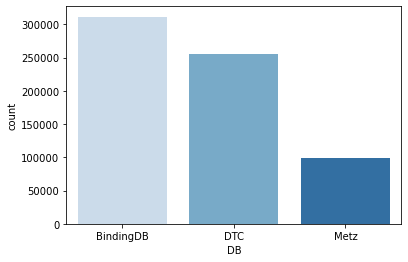

- 'BindingDB' : 311348
- 'DTC' : 255934
- 'Metz' : 99300


In [52]:
sns.countplot(x='DB', data=hkdf, palette='Blues')
plt.show()

for t, c in zip(hkdf.value_counts(['DB']).index.tolist(), hkdf.value_counts(['DB']).tolist()):
    print(f"- '{t[0]}' : {c}")

In [ ]:
# 데이터가 많은 기준으로 우선순위를 정해서 다시 정렬한다.
# Prioritize and rearrange data based on a lot of data.

In [53]:
hkdf1 = hkdf[hkdf['DB'] == 'BindingDB'].reset_index(drop=True).reset_index(drop=True)
hkdf2 = hkdf[hkdf['DB'] == 'DTC'].reset_index(drop=True).reset_index(drop=True)
hkdf3 = hkdf[hkdf['DB'] == 'Metz'].reset_index(drop=True).reset_index(drop=True)
hkdf1.shape[0], hkdf2.shape[0], hkdf3.shape[0]

(311348, 255934, 99300)

In [54]:
hkdf = pd.concat([hkdf1, hkdf2, hkdf3]).reset_index(drop=True)
hkdf

,Entry,Name,smiles,Qualifier,Value (nM),Value (log10nM),Type,DB,MSA,Position,Short MSA,SMILES,"Value (log10nM, +R)","Mean Value (log10nM, +R)"
0,Q05397,PTK2_HUMAN,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,=,1999.000000,3.300813,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,IELG------------RCIGEGQ-------FGDVHQGIYMSPEN--...,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...,3.300813,3.300813
1,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.540000,1.218536,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807,LIFN------------ESLGQGT-------FTKIFKGVRREVGDYG...,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,1.218536,1.218141
2,P52333,JAK3_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,226.900000,2.355834,IC50,BindingDB,LEWH----------------ENLGHGS----------------FTK...,521-779,LEWH------------ENLGHGS-------FTKIYRGCRHEVVDGE...,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,2.355834,2.355834
3,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.510000,1.217747,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807,LIFN------------ESLGQGT-------FTKIFKGVRREVGDYG...,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,1.217747,1.218141
4,Q05397,PTK2_HUMAN,CS(=O)(=O)c1ccc(cc1)C(=C)n1nc(NC(=O)Nc2ccc(cc2...,=,9999.000000,3.999957,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,IELG------------RCIGEGQ-------FGDVHQGIYMSPEN--...,C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...,3.999957,3.999957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666577,Q9UQM7,CAMK2A_HUMAN,Brc1ccc2cnc(Nc3ccncn3)cc2c1,<,3981.071706,3.600000,Ki,Metz,YQLF----------------EELGKGA----------------FSV...,13-271,YQLF------------EELGKGA-------FSVVRRCVKVL-----...,Brc1ccc2cnc(Nc3ccncn3)cc2c1,3.565929,3.590600
666578,Q00535,CDK5_HUMAN,Brc1ccc2cnc(Nc3ccncn3)cc2c1,=,158.489319,2.200000,Ki,Metz,YEKL----------------EKIGEGT----------------YGT...,4-286,YEKL------------EKIGEGT-------YGTVFKAKNRE-----...,Brc1ccc2cnc(Nc3ccncn3)cc2c1,2.200000,2.200001
666579,P00519,ABL1_HUMAN,Brc1ccc2cnc(Nc3ccncn3)cc2c1,<,2511.886432,3.400000,Ki,Metz,ITMK----------------HKLGGGQ----------------YGE...,242-495,ITMK------------HKLGGGQ-------YGEVYEGVWKK-----...,Brc1ccc2cnc(Nc3ccncn3)cc2c1,3.374350,3.402305
666580,Q07912,TNK2_HUMAN,Brc1ccc2cnc(Nc3ccncn3)cc2c1,<,3981.071706,3.600000,Ki,Metz,LRLL----------------EKLGDGS----------------FGV...,126-387,LRLL------------EKLGDGS-------FGVVRRGEWDAPSG--...,Brc1ccc2cnc(Nc3ccncn3)cc2c1,3.584713,3.597451


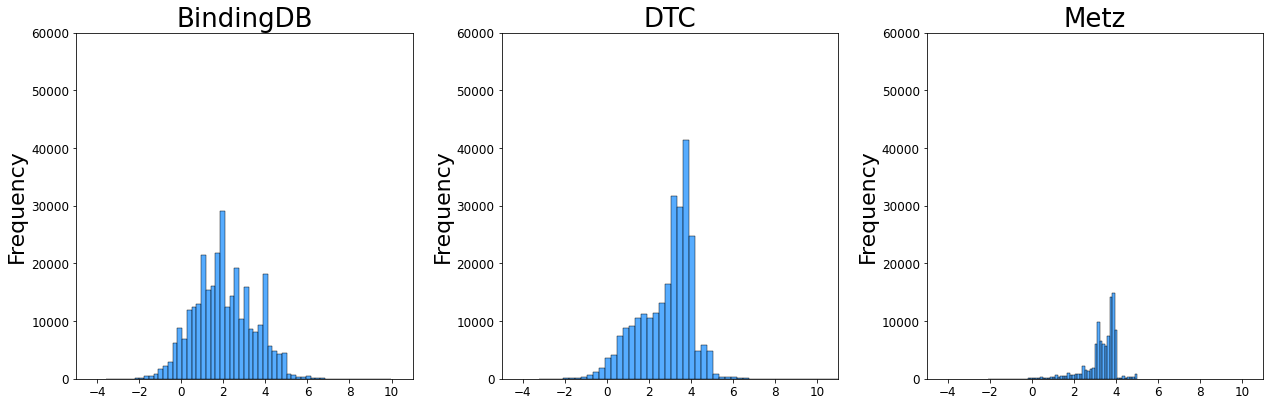

In [55]:
al = 0.2

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('BindingDB', fontsize=26)
sns.histplot(hkdf[hkdf['DB'] == 'BindingDB']['Value (log10nM)'].tolist(), color="dodgerblue", bins=60)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-5, 11])
plt.ylim([0, 60000])

plt.subplot(1, 3, 2)
plt.title('DTC', fontsize=26)
sns.histplot(hkdf[hkdf['DB'] == 'DTC']['Value (log10nM)'].tolist(), color="dodgerblue", bins=60)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-5, 11])
plt.ylim([0, 60000])

plt.subplot(1, 3, 3)
plt.title('Metz', fontsize=26)
sns.histplot(hkdf[hkdf['DB'] == 'Metz']['Value (log10nM)'].tolist(), color="dodgerblue", bins=60)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-5, 11])
plt.ylim([0, 60000])

plt.tight_layout(pad=2)
plt.show()

In [ ]:
# 중복을 제거한다.
# Eliminate duplicates.

In [56]:
hkdf = hkdf.drop_duplicates(['Entry', 'SMILES'], keep='first').reset_index(drop=True)
hkdf

,Entry,Name,smiles,Qualifier,Value (nM),Value (log10nM),Type,DB,MSA,Position,Short MSA,SMILES,"Value (log10nM, +R)","Mean Value (log10nM, +R)"
0,Q05397,PTK2_HUMAN,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,=,1999.000000,3.300813,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,IELG------------RCIGEGQ-------FGDVHQGIYMSPEN--...,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...,3.300813,3.300813
1,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.540000,1.218536,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807,LIFN------------ESLGQGT-------FTKIFKGVRREVGDYG...,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,1.218536,1.218141
2,P52333,JAK3_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,226.900000,2.355834,IC50,BindingDB,LEWH----------------ENLGHGS----------------FTK...,521-779,LEWH------------ENLGHGS-------FTKIYRGCRHEVVDGE...,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,2.355834,2.355834
3,Q05397,PTK2_HUMAN,CS(=O)(=O)c1ccc(cc1)C(=C)n1nc(NC(=O)Nc2ccc(cc2...,=,9999.000000,3.999957,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,IELG------------RCIGEGQ-------FGDVHQGIYMSPEN--...,C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...,3.999957,3.999957
4,O60674,JAK2_HUMAN,CS(=O)(=O)c1ccc(cc1)C(=C)n1nc(NC(=O)Nc2ccc(cc2...,=,9999.000000,3.999957,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807,LIFN------------ESLGQGT-------FTKIFKGVRREVGDYG...,C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...,3.999957,3.999957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391207,P00519,ABL1_HUMAN,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,<,2511.886432,3.400000,Ki,Metz,ITMK----------------HKLGGGQ----------------YGE...,242-495,ITMK------------HKLGGGQ-------YGEVYEGVWKK-----...,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,3.386740,3.386740
391208,Q07912,TNK2_HUMAN,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,<,3981.071706,3.600000,Ki,Metz,LRLL----------------EKLGDGS----------------FGV...,126-387,LRLL------------EKLGDGS-------FGVVRRGEWDAPSG--...,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,3.565991,3.565991
391209,Q04771,ACVR1_HUMAN,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,<,3981.071706,3.600000,Ki,Metz,ITLL----------------ECVGKGR----------------YGE...,208-497,ITLL------------ECVGKGR-------YGEVWRGSW-------...,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,3.576409,3.576409
391210,O00141,SGK1_HUMAN,Clc1cc2nn[nH]c2cc1Cl,<,10000.000000,4.000000,Ki,Metz,FHFL----------------KVIGKGS----------------FGK...,98-355,FHFL------------KVIGKGS-------FGKVLLARHKA-----...,Clc1cc2nn[nH]c2cc1Cl,3.964806,3.964806


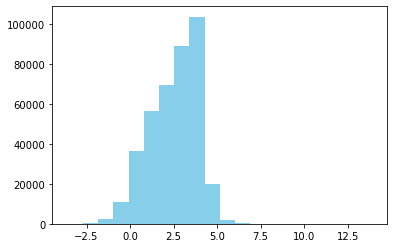

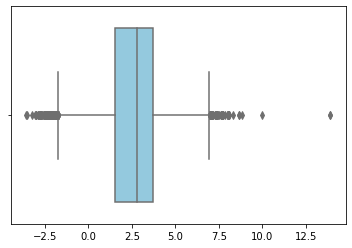

-3.59 13.9


In [57]:
v_list = hkdf['Mean Value (log10nM, +R)'].tolist()

plt.hist(v_list, bins=20, color='skyblue')
plt.show()

sns.boxplot(x=v_list, color='skyblue')
plt.show()

print(round(min(v_list), 2), round(max(v_list), 2))

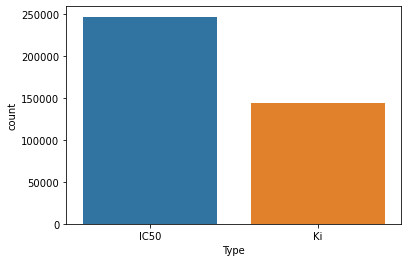

- IC50 : 246837
- Ki : 144375


In [58]:
sns.countplot(x='Type', data=hkdf)
plt.show()

for t, c in zip(hkdf.value_counts(['Type']).index.tolist(), hkdf.value_counts(['Type']).tolist()):
    print(f'- {t[0]} : {c}')

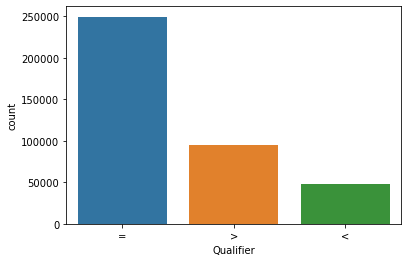

- '=' : 249360
- '>' : 94513
- '<' : 47339


In [59]:
sns.countplot(x='Qualifier', data=hkdf)
plt.show()

for t, c in zip(hkdf.value_counts(['Qualifier']).index.tolist(), hkdf.value_counts(['Qualifier']).tolist()):
    print(f"- '{t[0]}' : {c}")

In [60]:
hkdf.to_csv('humankinase_total_data.csv', index=False)

In [61]:
hkdf = pd.read_csv('humankinase_total_data.csv')
hkdf

,Entry,Name,smiles,Qualifier,Value (nM),Value (log10nM),Type,DB,MSA,Position,Short MSA,SMILES,"Value (log10nM, +R)","Mean Value (log10nM, +R)"
0,Q05397,PTK2_HUMAN,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,=,1999.000000,3.300813,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,IELG------------RCIGEGQ-------FGDVHQGIYMSPEN--...,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...,3.300813,3.300813
1,O60674,JAK2_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,16.540000,1.218536,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807,LIFN------------ESLGQGT-------FTKIFKGVRREVGDYG...,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,1.218536,1.218141
2,P52333,JAK3_HUMAN,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,=,226.900000,2.355834,IC50,BindingDB,LEWH----------------ENLGHGS----------------FTK...,521-779,LEWH------------ENLGHGS-------FTKIYRGCRHEVVDGE...,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,2.355834,2.355834
3,Q05397,PTK2_HUMAN,CS(=O)(=O)c1ccc(cc1)C(=C)n1nc(NC(=O)Nc2ccc(cc2...,=,9999.000000,3.999957,IC50,BindingDB,IELG----------------RCIGEGQ----------------FGD...,422-678,IELG------------RCIGEGQ-------FGDVHQGIYMSPEN--...,C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...,3.999957,3.999957
4,O60674,JAK2_HUMAN,CS(=O)(=O)c1ccc(cc1)C(=C)n1nc(NC(=O)Nc2ccc(cc2...,=,9999.000000,3.999957,IC50,BindingDB,LIFN----------------ESLGQGT----------------FTK...,545-807,LIFN------------ESLGQGT-------FTKIFKGVRREVGDYG...,C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...,3.999957,3.999957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391207,P00519,ABL1_HUMAN,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,<,2511.886432,3.400000,Ki,Metz,ITMK----------------HKLGGGQ----------------YGE...,242-495,ITMK------------HKLGGGQ-------YGEVYEGVWKK-----...,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,3.386740,3.386740
391208,Q07912,TNK2_HUMAN,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,<,3981.071706,3.600000,Ki,Metz,LRLL----------------EKLGDGS----------------FGV...,126-387,LRLL------------EKLGDGS-------FGVVRRGEWDAPSG--...,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,3.565991,3.565991
391209,Q04771,ACVR1_HUMAN,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,<,3981.071706,3.600000,Ki,Metz,ITLL----------------ECVGKGR----------------YGE...,208-497,ITLL------------ECVGKGR-------YGEVWRGSW-------...,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,3.576409,3.576409
391210,O00141,SGK1_HUMAN,Clc1cc2nn[nH]c2cc1Cl,<,10000.000000,4.000000,Ki,Metz,FHFL----------------KVIGKGS----------------FGK...,98-355,FHFL------------KVIGKGS-------FGKVLLARHKA-----...,Clc1cc2nn[nH]c2cc1Cl,3.964806,3.964806


In [62]:
hkdf = hkdf[['Entry', 'Name', 'Position', 'MSA', 'SMILES', 'Qualifier', 'Type', 'Value (nM)', 'Mean Value (log10nM, +R)', 'DB']]
hkdf = hkdf.rename(columns={'Mean Value (log10nM, +R)':'Value'})
hkdf = hkdf.rename(columns={'DB':'Database'})
hkdf

,Entry,Name,Position,MSA,SMILES,Qualifier,Type,Value (nM),Value,Database
0,Q05397,PTK2_HUMAN,422-678,IELG----------------RCIGEGQ----------------FGD...,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...,=,IC50,1999.000000,3.300813,BindingDB
1,O60674,JAK2_HUMAN,545-807,LIFN----------------ESLGQGT----------------FTK...,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,=,IC50,16.540000,1.218141,BindingDB
2,P52333,JAK3_HUMAN,521-779,LEWH----------------ENLGHGS----------------FTK...,Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...,=,IC50,226.900000,2.355834,BindingDB
3,Q05397,PTK2_HUMAN,422-678,IELG----------------RCIGEGQ----------------FGD...,C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...,=,IC50,9999.000000,3.999957,BindingDB
4,O60674,JAK2_HUMAN,545-807,LIFN----------------ESLGQGT----------------FTK...,C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...,=,IC50,9999.000000,3.999957,BindingDB
...,...,...,...,...,...,...,...,...,...,...
391207,P00519,ABL1_HUMAN,242-495,ITMK----------------HKLGGGQ----------------YGE...,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,<,Ki,2511.886432,3.386740,Metz
391208,Q07912,TNK2_HUMAN,126-387,LRLL----------------EKLGDGS----------------FGV...,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,<,Ki,3981.071706,3.565991,Metz
391209,Q04771,ACVR1_HUMAN,208-497,ITLL----------------ECVGKGR----------------YGE...,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...,<,Ki,3981.071706,3.576409,Metz
391210,O00141,SGK1_HUMAN,98-355,FHFL----------------KVIGKGS----------------FGK...,Clc1cc2nn[nH]c2cc1Cl,<,Ki,10000.000000,3.964806,Metz


In [63]:
hkdf = hkdf.sort_values(['Entry']).reset_index(drop=True)
hkdf = hkdf.sort_values(['Database']).reset_index(drop=True)
hkdf

,Entry,Name,Position,MSA,SMILES,Qualifier,Type,Value (nM),Value,Database
0,P35968,KDR_HUMAN,834-1162,LKLG----------------KPLGRGA----------------FGQ...,COc1ccccc1NC(=O)Nc1ccc2c(c1)c1c3c(c4c(c1n2CC(C...,=,IC50,41.000000,1.612784,BindingDB
1,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,O=c1c2ccc(Br)cc2c(-c2ccccc2)c(CO)n1CC1CCCCC1,=,IC50,1400.000000,3.146128,BindingDB
2,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1CC1CCCCC1,=,IC50,450.000000,2.653213,BindingDB
3,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1CCc1cc...,=,IC50,1100.000000,3.041393,BindingDB
4,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,=,IC50,100.000000,2.000000,BindingDB
...,...,...,...,...,...,...,...,...,...,...
391207,Q9NYL2,MAP3K20_HUMAN,16-262,LQFF----------------ENCGGGS----------------FGS...,Cc1cc(C)c(/C=C2\C(=O)Nc3ccccc32)[nH]1,<,Ki,7943.282347,3.877649,Metz
391208,P51957,NEK4_HUMAN,6-261,YCYL----------------RVVGKGS----------------YGE...,COc1cccc([C@@H](C)NC(=O)c2ccc(-c3ccncn3)cc2)c1,<,Ki,6309.573445,3.774225,Metz
391209,Q5VT25,CDC42BPA_HUMAN,77-343,FEIL----------------KVIGRGA----------------FGE...,Cc1cc(Nc2cc(N3CCN(C)CC3)nc(Sc3ccc(NC(=O)C4CC4)...,<,Ki,10000.000000,3.962354,Metz
391210,Q9NYL2,MAP3K20_HUMAN,16-262,LQFF----------------ENCGGGS----------------FGS...,O=C(N/N=C/c1ccc(Sc2nc3ccccc3[nH]2)o1)c1cccc([N...,<,Ki,7943.282347,3.878941,Metz


In [64]:
len(list(set(hkdf['Entry'].tolist()))), len(list(set(hkdf['Name'].tolist()))), len(list(set(hkdf['MSA'].tolist())))

(404, 404, 404)

In [65]:
len(list(set(hkdf['SMILES'].tolist())))

171107

In [66]:
hkdf.to_csv('kpro_data_total.csv', index=False)

In [67]:
hkdf = pd.read_csv('kpro_data_total.csv', low_memory=False)
hkdf

,Entry,Name,Position,MSA,SMILES,Qualifier,Type,Value (nM),Value,Database
0,P35968,KDR_HUMAN,834-1162,LKLG----------------KPLGRGA----------------FGQ...,COc1ccccc1NC(=O)Nc1ccc2c(c1)c1c3c(c4c(c1n2CC(C...,=,IC50,41.000000,1.612784,BindingDB
1,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,O=c1c2ccc(Br)cc2c(-c2ccccc2)c(CO)n1CC1CCCCC1,=,IC50,1400.000000,3.146128,BindingDB
2,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1CC1CCCCC1,=,IC50,450.000000,2.653213,BindingDB
3,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1CCc1cc...,=,IC50,1100.000000,3.041393,BindingDB
4,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,=,IC50,100.000000,2.000000,BindingDB
...,...,...,...,...,...,...,...,...,...,...
391207,Q9NYL2,MAP3K20_HUMAN,16-262,LQFF----------------ENCGGGS----------------FGS...,Cc1cc(C)c(/C=C2\C(=O)Nc3ccccc32)[nH]1,<,Ki,7943.282347,3.877649,Metz
391208,P51957,NEK4_HUMAN,6-261,YCYL----------------RVVGKGS----------------YGE...,COc1cccc([C@@H](C)NC(=O)c2ccc(-c3ccncn3)cc2)c1,<,Ki,6309.573445,3.774225,Metz
391209,Q5VT25,CDC42BPA_HUMAN,77-343,FEIL----------------KVIGRGA----------------FGE...,Cc1cc(Nc2cc(N3CCN(C)CC3)nc(Sc3ccc(NC(=O)C4CC4)...,<,Ki,10000.000000,3.962354,Metz
391210,Q9NYL2,MAP3K20_HUMAN,16-262,LQFF----------------ENCGGGS----------------FGS...,O=C(N/N=C/c1ccc(Sc2nc3ccccc3[nH]2)o1)c1cccc([N...,<,Ki,7943.282347,3.878941,Metz


In [68]:
print('- Data', hkdf.shape[0])
print('- Kinase', len(list(set(hkdf['Entry'].unique()))))
print('- Compound', len(list(set(hkdf['SMILES'].unique()))))

- Data 391212
- Kinase 404
- Compound 171107


In [ ]:
# 후보물질이 될만한 분자만 남긴다.
# Only molecules that can be candidates are left.

In [69]:
TAG = "umols"
fn_l_midsmi = "kpro_data_total.csv"
um = Umols(TAG)
um.Read_l_midsmi(fn_l_midsmi, col_mid='SMILES', col_smi='SMILES', sep=',')
um.Clean()
um.Dump(TAG)

#Umols>Err in Clean>out-of-mwRange!!, mw=126.2
#Umols>Err in Clean>out-of-mwRange!!, mw=118.1
#Umols>Err in Clean>out-of-mwRange!!, mw=3993.7
#Umols>Err in Clean>out-of-mwRange!!, mw=1091.2
#Umols>Err in Clean>out-of-mwRange!!, mw=195.2
#Umols>Err in Clean>out-of-mwRange!!, mw=180.2
#Umols>Err in Clean>out-of-mwRange!!, mw=856.0
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 130
#Umols>Err in Clean>out-of-mwRange!!, mw=832.0
#Umols>Err in Clean>out-of-mwRange!!, mw=878.0
#Umols>Err in Clean>out-of-mwRange!!, mw=873.0
#Umols>Err in Clean>out-of-mwRange!!, mw=843.0
#Umols>Err in Clean>out-of-mwRange!!, mw=825.0
#Umols>Err in Clean>out-of-mwRange!!, mw=826.0
#Umols>Err in Clean>out-of-mwRange!!, mw=841.0
#Umols>Err in Clean>out-of-mwRange!!, mw=831.0
#Umols>Err in Clean>token is not OK!!, csmi= CN1CCN(C(=O)c2cc3cc(Nc4nccc(-c5cc(OC6CCOc7ccccc76)ccn5)n4)ccc3[nH]2)CC1
#Umols>Err in Clean>out-of-mwRange!!, mw=872.1
#Umols>Err in Clean>out-of-mwRange!!, mw=888.1
#Umols>Err in Clean>out-of-mwRa

#Umols>Err in Clean>out-of-mwRange!!, mw=832.9
#Umols>Err in Clean>out-of-mwRange!!, mw=833.9
#Umols>Err in Clean>token is not OK!!, csmi= N#CCC(=O)N1CC=C(c2cc3c(-c4cccc(N5CCOc6cc(C7CC7)cc(F)c6C5=O)c4CO)ccnc3[nH]2)CC1
#Umols>Err in Clean>out-of-mwRange!!, mw=1090.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1080.4
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 108
#Umols>Err in Clean>out-of-mwRange!!, mw=828.6
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 132
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 108
#Umols>Err in Clean>out-of-mwRange!!, mw=827.0
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 110
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 115
#Umols>Err in Clean>out-of-mwRange!!, mw=809.9
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 104
#Umols>Err in Clean>out-of-mwRange!!, mw=846.0
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 106
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 106
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 112
#Umols>Err in Clean>max_len_csmi!!, len

#Umols>Err in Clean>out-of-mwRange!!, mw=1047.1
#Umols>Err in Clean>out-of-mwRange!!, mw=2034.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1080.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1421.7
#Umols>Err in Clean>out-of-mwRange!!, mw=1094.2
#Umols>Err in Clean>out-of-mwRange!!, mw=189.3
#Umols>Err in Clean>out-of-mwRange!!, mw=1412.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1421.7
#Umols>Err in Clean>out-of-mwRange!!, mw=1385.7
#Umols>Err in Clean>out-of-mwRange!!, mw=1286.6
#Umols>Err in Clean>out-of-mwRange!!, mw=1158.4
#Umols>Err in Clean>out-of-mwRange!!, mw=963.0
#Umols>Err in Clean>out-of-mwRange!!, mw=1132.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1229.5
#Umols>Err in Clean>out-of-mwRange!!, mw=998.0
#Umols>Err in Clean>out-of-mwRange!!, mw=2034.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1335.5
#Umols>Err in Clean>out-of-mwRange!!, mw=942.3
#Umols>Err in Clean>out-of-mwRange!!, mw=807.9
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 134
#Umols>Err in Clean>out-of-mwRange!!, mw=8

#Umols>Err in Clean>out-of-mwRange!!, mw=167.2
#Umols>Err in Clean>out-of-mwRange!!, mw=188.3
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=161.2
#Umols>Err in Clean>out-of-mwRange!!, mw=180.6
#Umols>Err in Clean>out-of-mwRange!!, mw=153.2
#Umols>Err in Clean>out-of-mwRange!!, mw=151.2
#Umols>Err in Clean>out-of-mwRange!!, mw=156.2
#Umols>Err in Clean>out-of-mwRange!!, mw=179.2
#Umols>Err in Clean>out-of-mwRange!!, mw=196.2
#Umols>Err in Clean>out-of-mwRange!!, mw=198.3
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 104
#Umols>Err in Clean>out-of-mwRange!!, mw=176.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1630.9
#Umols>Err in Clean>out-of-mwRange!!, mw=176.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1634.8
#Umols>Err in Clean>out-of-mwRange!!, mw=183.2
#Umols>Err in Clean>out-of-mwRange!!, mw=163.2
#Umols>Err in Clean>out-of-mwRange!!, mw=198.3
#Umols>Err in Clean>out-of-mwRange!!, mw=178.2
#Umols>

In [70]:
fp = open("%s/umols.pickle" % TAG, 'rb')
tag = cPickle.load(fp)
bool_chkin = cPickle.load(fp)
bool_clean = cPickle.load(fp)
l_midsmi = cPickle.load(fp)
l_cln_midcsmi = cPickle.load(fp)
l_cln_mids = cPickle.load(fp)
l_cln_csmi = cPickle.load(fp)
l_uniq_csmi = cPickle.load(fp)
l_skip_mids = cPickle.load(fp)
d_cln_mid2csmi = cPickle.load(fp)
d_cln_csmi2mids = cPickle.load(fp)
fp.close()

In [71]:
def getsmi(smi):
    m = Chem.MolFromSmiles(smi)
    mols = rdmolops.GetMolFrags(m, asMols=True)
    m0 = max(mols, key=lambda m: m.GetNumAtoms())
    csmi = Chem.MolToSmiles(m0, isomericSmiles=True, canonical=True)
    if csmi in l_uniq_csmi:
        return Chem.MolToSmiles(Chem.MolFromSmiles(csmi))
    else:
        return 0

In [72]:
smi = parmap.map(getsmi, hkdf['SMILES'].tolist(), pm_pbar=True, pm_processes=100)

hkdf['SMILES'] = smi
hkdf = hkdf[hkdf['SMILES'] != 0].reset_index(drop=True)
hkdf

  0%|          | 0/391212 [00:00<?, ?it/s]

,Entry,Name,Position,MSA,SMILES,Qualifier,Type,Value (nM),Value,Database
0,P35968,KDR_HUMAN,834-1162,LKLG----------------KPLGRGA----------------FGQ...,COc1ccccc1NC(=O)Nc1ccc2c(c1)c1c3c(c4c(c1n2CC(C...,=,IC50,41.000000,1.612784,BindingDB
1,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,O=c1c2ccc(Br)cc2c(-c2ccccc2)c(CO)n1CC1CCCCC1,=,IC50,1400.000000,3.146128,BindingDB
2,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1CC1CCCCC1,=,IC50,450.000000,2.653213,BindingDB
3,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1CCc1cc...,=,IC50,1100.000000,3.041393,BindingDB
4,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,=,IC50,100.000000,2.000000,BindingDB
...,...,...,...,...,...,...,...,...,...,...
385539,Q9NYL2,MAP3K20_HUMAN,16-262,LQFF----------------ENCGGGS----------------FGS...,Cc1cc(C)c(/C=C2\C(=O)Nc3ccccc32)[nH]1,<,Ki,7943.282347,3.877649,Metz
385540,P51957,NEK4_HUMAN,6-261,YCYL----------------RVVGKGS----------------YGE...,COc1cccc([C@@H](C)NC(=O)c2ccc(-c3ccncn3)cc2)c1,<,Ki,6309.573445,3.774225,Metz
385541,Q5VT25,CDC42BPA_HUMAN,77-343,FEIL----------------KVIGRGA----------------FGE...,Cc1cc(Nc2cc(N3CCN(C)CC3)nc(Sc3ccc(NC(=O)C4CC4)...,<,Ki,10000.000000,3.962354,Metz
385542,Q9NYL2,MAP3K20_HUMAN,16-262,LQFF----------------ENCGGGS----------------FGS...,O=C(N/N=C/c1ccc(Sc2nc3ccccc3[nH]2)o1)c1cccc([N...,<,Ki,7943.282347,3.878941,Metz


In [73]:
hkdf.to_csv("./kpro_data_total_final.csv", index=False)

In [74]:
hkdf = pd.read_csv("./kpro_data_total_final.csv")
hkdf

,Entry,Name,Position,MSA,SMILES,Qualifier,Type,Value (nM),Value,Database
0,P35968,KDR_HUMAN,834-1162,LKLG----------------KPLGRGA----------------FGQ...,COc1ccccc1NC(=O)Nc1ccc2c(c1)c1c3c(c4c(c1n2CC(C...,=,IC50,41.000000,1.612784,BindingDB
1,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,O=c1c2ccc(Br)cc2c(-c2ccccc2)c(CO)n1CC1CCCCC1,=,IC50,1400.000000,3.146128,BindingDB
2,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1CC1CCCCC1,=,IC50,450.000000,2.653213,BindingDB
3,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1CCc1cc...,=,IC50,1100.000000,3.041393,BindingDB
4,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,=,IC50,100.000000,2.000000,BindingDB
...,...,...,...,...,...,...,...,...,...,...
385539,Q9NYL2,MAP3K20_HUMAN,16-262,LQFF----------------ENCGGGS----------------FGS...,Cc1cc(C)c(/C=C2\C(=O)Nc3ccccc32)[nH]1,<,Ki,7943.282347,3.877649,Metz
385540,P51957,NEK4_HUMAN,6-261,YCYL----------------RVVGKGS----------------YGE...,COc1cccc([C@@H](C)NC(=O)c2ccc(-c3ccncn3)cc2)c1,<,Ki,6309.573445,3.774225,Metz
385541,Q5VT25,CDC42BPA_HUMAN,77-343,FEIL----------------KVIGRGA----------------FGE...,Cc1cc(Nc2cc(N3CCN(C)CC3)nc(Sc3ccc(NC(=O)C4CC4)...,<,Ki,10000.000000,3.962354,Metz
385542,Q9NYL2,MAP3K20_HUMAN,16-262,LQFF----------------ENCGGGS----------------FGS...,O=C(N/N=C/c1ccc(Sc2nc3ccccc3[nH]2)o1)c1cccc([N...,<,Ki,7943.282347,3.878941,Metz


In [75]:
print('- Data', hkdf.shape[0])
print('- Kinase', len(list(set(hkdf['Entry'].unique()))))
print('- Compound', len(list(set(hkdf['SMILES'].unique()))))

- Data 385544
- Kinase 402
- Compound 168072


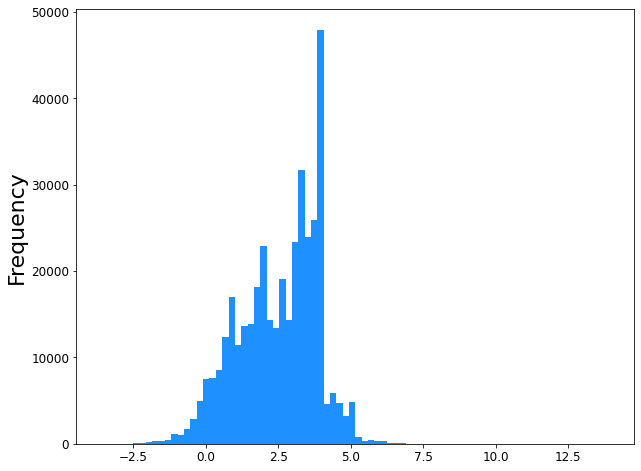

In [76]:
al = 0.2
lw = 2

plt.figure(figsize=(10, 8))
plt.hist(hkdf['Value'].tolist(), 
         color="dodgerblue", bins=80)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim([-11, 11])
plt.show()

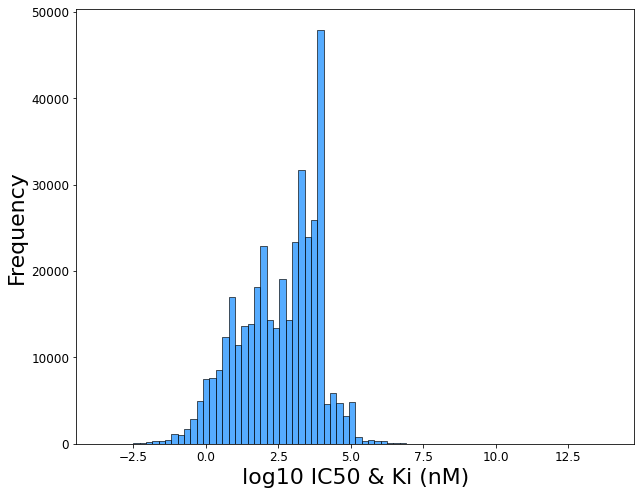

In [77]:
al = 0.2
lw = 2

plt.figure(figsize=(10, 8))
sns.histplot(hkdf['Value'].tolist(), color="dodgerblue", bins=80)
plt.ylabel('Frequency', fontsize=22)
plt.xlabel('log10 IC50 & Ki (nM)', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim([-11, 11])
plt.show()

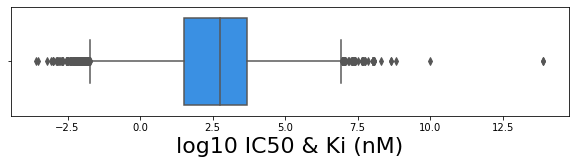

-3.59 13.9


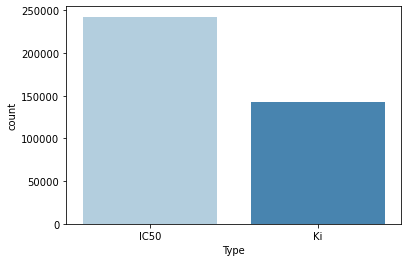

- IC50 : 242678
- Ki : 142866


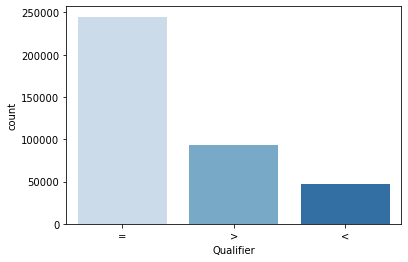

- '=' : 244963
- '>' : 93473
- '<' : 47108


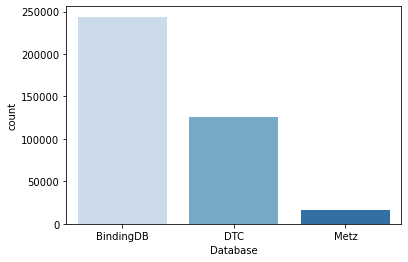

- 'BindingDB' : 243932
- 'DTC' : 125829
- 'Metz' : 15783


In [78]:
v_list = hkdf['Value'].tolist()

plt.figure(figsize=(10, 2))

sns.boxplot(x=v_list, color='dodgerblue')
plt.xlabel('log10 IC50 & Ki (nM)', fontsize=22)
plt.show()

print(round(min(v_list), 2), round(max(v_list), 2))

sns.countplot(x='Type', data=hkdf, palette='Blues')
plt.show()

for t, c in zip(hkdf.value_counts(['Type']).index.tolist(), hkdf.value_counts(['Type']).tolist()):
    print(f'- {t[0]} : {c}')

sns.countplot(x='Qualifier', data=hkdf, palette='Blues')
plt.show()

for t, c in zip(hkdf.value_counts(['Qualifier']).index.tolist(), hkdf.value_counts(['Qualifier']).tolist()):
    print(f"- '{t[0]}' : {c}")

sns.countplot(x='Database', data=hkdf, palette='Blues')
plt.show()

for t, c in zip(hkdf.value_counts(['Database']).index.tolist(), hkdf.value_counts(['Database']).tolist()):
    print(f"- '{t[0]}' : {c}")

In [79]:
print(hkdf.shape[0])
print(len(list(set(hkdf['Entry'].tolist()))), len(list(set(hkdf['Name'].tolist()))), len(list(set(hkdf['MSA'].tolist()))))
print(len(list(set(hkdf['SMILES'].tolist()))))

385544
402 402 402
168072


In [80]:
diffkis

['O75582',
 'P23458',
 'P52333',
 'Q5VST9',
 'Q9UK32',
 'P29597',
 'Q15772',
 'Q15349',
 'O75676',
 'Q15418',
 'P51812',
 'O60674',
 'Q9P2K8']

In [81]:
train_df = hkdf[hkdf['Database'] != 'Metz'].reset_index(drop=True)
test_df = hkdf[hkdf['Database'] == 'Metz'].reset_index(drop=True)
train_df.shape[0], test_df.shape[0]

(369761, 15783)

In [82]:
si5 = pd.read_excel('./Dunbrack/si5.xlsx')
for i in range(si5.shape[0]):
    if '_' in si5['2_Gene'].iloc[i]:
        si5['2_Gene'].iloc[i] = si5['2_Gene'].iloc[i][:-2]
si5 = si5.drop_duplicates(['2_Gene'], keep='first').reset_index(drop=True)
si5

,1_Group,2_Gene,3_HGNC,4_Uni_entry,5_Uni_acc,6_Domain_begin,7_Domain_end,8_Domain_length,9_Largest_insert_length,10_PDB_validation,11_Conformational_state,12_Dihedral_state,13_Group_in_Uni,14_Group_in_Manning,15_Synonymn
0,AGC,AKT1,HGNC:391,AKT1_HUMAN,P31749,150,408,259,9,6NPZB,DFGin,BLAminus,AGC,AGC,"PKB,RAC"
1,AGC,AKT2,HGNC:392,AKT2_HUMAN,P31751,152,409,258,9,3E8DB,DFGin,BLAminus,AGC,AGC,NaN
2,AGC,AKT3,HGNC:393,AKT3_HUMAN,Q9Y243,148,405,258,9,NaN,NaN,NaN,AGC,AGC,PKBG
3,AGC,CDC42BPA,HGNC:1737,MRCKA_HUMAN,Q5VT25,77,343,267,14,NaN,NaN,NaN,AGC,AGC,KIAA0451
4,AGC,CDC42BPB,HGNC:1738,MRCKB_HUMAN,Q9Y5S2,76,342,267,14,5OTFA,DFGin,BLAminus,AGC,AGC,KIAA1124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,TYR,TXK,HGNC:12434,TXK_HUMAN,P42681,271,522,252,10,NaN,NaN,NaN,TYR,TYR,"PTK4,RLK"
480,TYR,TYK2,HGNC:12440,TYK2_HUMAN,P29597,589,868,280,26,3ZONA,DFGin,NaN,TYR,TYR,NaN
481,TYR,TYRO3,HGNC:12446,TYRO3_HUMAN,Q06418,518,788,271,10,NaN,NaN,NaN,TYR,TYR,"BYK,DTK,RSE,SKY,TIF"
482,TYR,YES1,HGNC:12841,YES_HUMAN,P07947,277,528,252,10,NaN,NaN,NaN,TYR,TYR,YES


In [83]:
len(test_df['Entry'].unique())

170

In [84]:
gs = []
for e in test_df['Entry'].unique().tolist()+['P11802']:
    gs.append(si5[si5['5_Uni_acc'] == e]['13_Group_in_Uni'].tolist()[0])

In [85]:
len(list(set(gs)))

9

In [86]:
for g in list(set(gs)):
    print(g, gs.count(g))

OTHER 13
CK1 5
CAMK 32
CMGC 27
AGC 23
STE 14
TYR 49
NEK 2
TKL 6


In [ ]:
# 2개 이상의 도메인을 가지는 키나아제는 제외합니다.
# Excludes kinases with two or more domains.

In [87]:
def getdiff(entry):
    if entry in diffkis:
        return 1
    else:
        return 0

diff = parmap.map(getdiff, train_df['Entry'].tolist(), 
                    pm_pbar=True, pm_processes=100)

train_df['Diff'] = diff
train_df

  0%|          | 0/369761 [00:00<?, ?it/s]

,Entry,Name,Position,MSA,SMILES,Qualifier,Type,Value (nM),Value,Database,Diff
0,P35968,KDR_HUMAN,834-1162,LKLG----------------KPLGRGA----------------FGQ...,COc1ccccc1NC(=O)Nc1ccc2c(c1)c1c3c(c4c(c1n2CC(C...,=,IC50,41.00,1.612784,BindingDB,0
1,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,O=c1c2ccc(Br)cc2c(-c2ccccc2)c(CO)n1CC1CCCCC1,=,IC50,1400.00,3.146128,BindingDB,0
2,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1CC1CCCCC1,=,IC50,450.00,2.653213,BindingDB,0
3,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1CCc1cc...,=,IC50,1100.00,3.041393,BindingDB,0
4,P45983,MAPK8_HUMAN,26-321,YQNL----------------KPIGSGA----------------QGI...,COC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,=,IC50,100.00,2.000000,BindingDB,0
...,...,...,...,...,...,...,...,...,...,...,...
369756,P53350,PLK1_HUMAN,53-305,YVRG----------------RFLGKGG----------------FAK...,CCOc1ccn(-c2ccc(F)cc2)c(=O)c1C(=O)Nc1ccc(Oc2cc...,>,IC50,2000.00,3.334396,DTC,0
369757,P07333,CSF1R_HUMAN,582-912,LQFG----------------KTLGAGA----------------FGK...,COc1ncnc2[nH]cc(C(=O)c3c(F)ccc(NS(=O)(=O)c4ccc...,<,IC50,10000.00,3.998767,DTC,0
369758,P53350,PLK1_HUMAN,53-305,YVRG----------------RFLGKGG----------------FAK...,NC(=O)c1cc2c(-c3ccc(F)cc3F)cncc2s1,=,Ki,1995.26,3.300000,DTC,0
369759,P53350,PLK1_HUMAN,53-305,YVRG----------------RFLGKGG----------------FAK...,COc1cc(-c2ccc3[nH]nc(C(=O)Nc4ccccc4)c3c2)ccc1O,>,Ki,7943.28,3.914122,DTC,0


In [88]:
train_df = train_df[train_df['Diff'] == 0].reset_index(drop=True)
test_df = pd.concat([test_df, train_df[train_df['Diff'] == 1]]).reset_index(drop=True)

In [89]:
del train_df['Diff']
del test_df['Diff']

In [90]:
print(train_df.shape[0])
print(len(list(set(train_df['Entry'].tolist()))))
print(len(list(set(train_df['SMILES'].tolist()))))
print(test_df.shape[0])
print(len(list(set(test_df['Entry'].tolist()))))
print(len(list(set(test_df['SMILES'].tolist()))))

337226
391
156326
15783
170
609


In [91]:
print(test_df.shape[0])
print(len(list(set(test_df['Entry'].tolist()))))
print(len(list(set(test_df['SMILES'].tolist()))))

15783
170
609


In [97]:
print('- Train')
print('- Data', train_df.shape[0])
print('- Kinase', len(list(set(train_df['Entry'].tolist()))))
print('- Compound', len(list(set(train_df['SMILES'].tolist()))))
print()
print('- Test')
print('- Data', test_df.shape[0])
print('- Kinase', len(list(set(test_df['Entry'].tolist()))))
print('- Compound', len(list(set(test_df['SMILES'].tolist()))))

- Train
- Data 337212
- Kinase 391
- Compound 156318

- Test
- Data 15271
- Kinase 165
- Compound 618


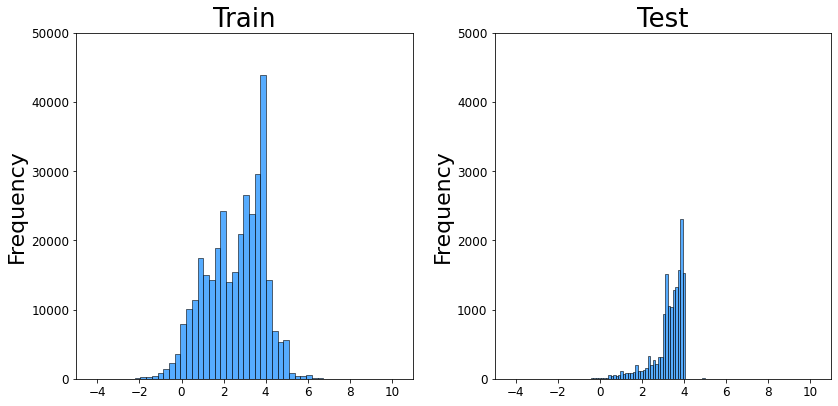

In [94]:
al = 0.2

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Train', fontsize=26)
sns.histplot(train_df['Value'].tolist(), color="dodgerblue", bins=50)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-5, 11])
plt.ylim([0, 50000])

plt.subplot(1, 2, 2)
plt.title('Test', fontsize=26)
sns.histplot(test_df['Value'].tolist(), color="dodgerblue", bins=50)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-5, 11])
plt.ylim([0, 5000])

plt.tight_layout(pad=2)
plt.show()

In [63]:
# train_df.to_csv("./kpro_data_train.csv", index=False)
# test_df.to_csv("./kpro_data_test.csv", index=False)